# Customer Attrition Model - Part 4
## Customer Churn Prediction

# 4.0 Notebook Brief

Upon clustering of the customer type for 4 clusters, these information are then used to train the prediction model for churn. 

## 4.1 Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import preprocessing library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#import prepocessing
from sklearn.preprocessing import StandardScaler

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.naive_bayes import GaussianNB

#import metrics
from sklearn.metrics import confusion_matrix, plot_roc_curve, r2_score

#import bootstrap libs
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

In [2]:
telco_final = pd.read_csv('../data/telco_clustered.csv')
pd.set_option('display.max_columns',99)

In [3]:
#drop cities
telco = telco_final.copy().drop(columns=['city','churn_reason', 'churn_category','churn_value', 'churn_score',
                            'internet_type','pop_density', 'tenure_months', 'dependents','satisfaction_score','new_user',
                            'referred_a_friend','total_charges','monthly_charge','avg_monthly_long_distance_charges'])

## OHE

In [4]:
telco_dummies = pd.get_dummies(telco, drop_first=True)

In [5]:
telco_dummies.head()

,gender,age,under_30,senior_citizen,married,number_of_dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,cltv,number_of_referrals,avg_monthly_gb_download,streaming_music,unlimited_data,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,internet_service_Fiber optic,internet_service_No,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E,cluster_minimalist,cluster_price_sensitive,cluster_vanilla
0,0,78,0,1,0,0,0,0,0,0,1,0,0,1,1,5433,0,8,0,0,0.00,20,0.00,59.65,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,74,0,1,1,1,1,1,0,1,0,0,0,0,1,5302,1,17,0,1,0.00,0,390.80,1024.10,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
2,0,71,0,1,0,3,1,1,0,0,0,0,1,1,1,3179,0,52,1,1,45.61,0,203.94,1910.88,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,1,78,0,1,1,1,1,0,0,1,1,0,1,1,1,5337,1,12,0,1,13.43,0,494.00,2995.07,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,1,80,0,1,1,1,1,1,0,0,0,0,0,0,1,2793,1,14,0,1,0.00,0,234.21,3102.36,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0


## Train Test Split

In [6]:
X = telco_dummies.drop(columns=['customer_status'])
y = telco_dummies.customer_status

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify = y, 
                                                    test_size=0.2,
                                                   random_state=42)

In [8]:
y.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: customer_status, dtype: float64

## Logistic Regression with SMOTE

In [9]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__penalty' : ['l2'],
    'logreg__solver' : ['lbfgs','liblinear'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_train, y_train)
best_logreg = gs.best_estimator_

print(f'Training Accuracy: {best_logreg.score(X_train, y_train):.2f}')
print(f'Testing Accuracy: {best_logreg.score(X_test, y_test):.2f}')
print('\n')
gs.best_params_

Training Accuracy: 0.78
Testing Accuracy: 0.78




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__penalty': 'l2',
 'logreg__solver': 'lbfgs'}

## Random Forests with SMOTE

In [10]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

#set pipe params
pipe_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [5, 7],
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5, n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_

print(f'Training Accuracy: {best_rf.score(X_train, y_train):.2f}')
print(f'Testing Accuracy: {best_rf.score(X_test, y_test):.2f}')
print('\n')
gs.best_params_

Training Accuracy: 0.82
Testing Accuracy: 0.81




{'rf__max_depth': 7, 'rf__n_estimators': 100}

## SVM with SMOTE

In [11]:
#Instantiate pipeline 
pipe = Pipeline([
    ('ss' , StandardScaler()),
    ('oversample', SMOTE(random_state=42)),
    ('svc', SVC(random_state=42))
])

#set pipe params
pipe_params = {
    'svc__kernel': ['rbf','poly'],
    'svc__C': [0.01,0.1,0.5],
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_train, y_train)
best_svc = gs.best_estimator_

print(f'Training Accuracy: {best_svc.score(X_train, y_train):.2f}')
print(f'Testing Accuracy:{ best_svc.score(X_test, y_test):.2f}')
print('\n')
gs.best_params_

Training Accuracy: 0.79
Testing Accuracy:0.79




{'svc__C': 0.01, 'svc__kernel': 'rbf'}

## Model Selection

In [12]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Balanced Baseline','Logistic Regression','Random Forest', 'SVM'],
    'Training Accuracy' : [0.5, best_logreg.score(X_train, y_train), best_rf.score(X_train, y_train), best_svc.score(X_train, y_train)],
    'Test Accuracy' : [0.5 ,best_logreg.score(X_test, y_test), best_rf.score(X_test, y_test), best_svc.score(X_test, y_test)]
})

model_df[['Training Accuracy', 'Test Accuracy']] = model_df[['Training Accuracy', 'Test Accuracy']].round(3)
model_df

,Model,Training Accuracy,Test Accuracy
0,Balanced Baseline,0.500,0.500
1,Logistic Regression,0.783,0.785
2,Random Forest,0.820,0.806
3,SVM,0.795,0.789


## Neural Networks 

In [13]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [14]:
over = SMOTE(random_state=42)
X_train_res, y_train_res = over.fit_resample(X_train_sc, y_train)

In [15]:
m, n_features = X_train.shape

In [16]:
model = Sequential()

model.add(Dense(n_features, input_dim=n_features, activation='relu', kernel_regularizer='l1'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
          
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=10)

hist = model.fit(X_train_res, y_train_res, validation_data=(X_test_sc, y_test), epochs=80, 
                 batch_size=256, callbacks=[early_stop])

Epoch 1/80
33/33 [==============================] - 2s 25ms/step - loss: 2.7170 - accuracy: 0.5045 - val_loss: 2.3344 - val_accuracy: 0.7218
Epoch 2/80
33/33 [==============================] - 0s 3ms/step - loss: 2.2380 - accuracy: 0.5788 - val_loss: 1.8817 - val_accuracy: 0.7516
Epoch 3/80
33/33 [==============================] - 0s 3ms/step - loss: 1.7938 - accuracy: 0.6786 - val_loss: 1.4447 - val_accuracy: 0.7637
Epoch 4/80
33/33 [==============================] - 0s 3ms/step - loss: 1.4203 - accuracy: 0.7597 - val_loss: 1.1551 - val_accuracy: 0.7644
Epoch 5/80
33/33 [==============================] - 0s 3ms/step - loss: 1.1256 - accuracy: 0.7874 - val_loss: 0.9333 - val_accuracy: 0.7587
Epoch 6/80
33/33 [==============================] - 0s 3ms/step - loss: 0.9070 - accuracy: 0.7928 - val_loss: 0.7613 - val_accuracy: 0.7708
Epoch 7/80
33/33 [==============================] - 0s 3ms/step - loss: 0.7362 - accuracy: 0.8024 - val_loss: 0.6315 - val_accuracy: 0.7729
Epoch 8/80
33/33 [=

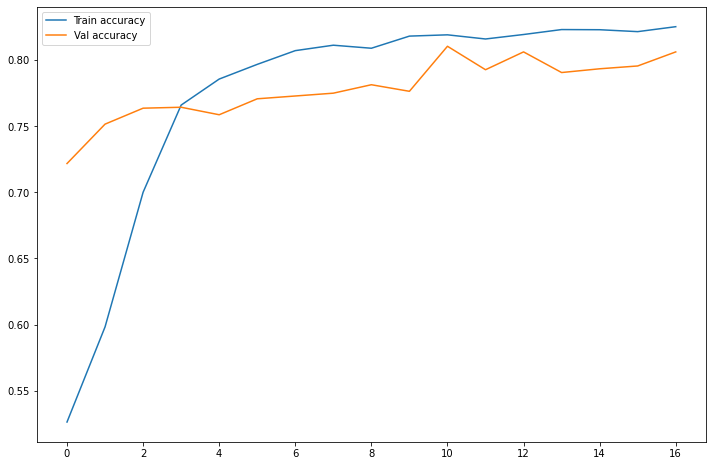

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(hist.history['accuracy'], label='Train accuracy')
plt.plot(hist.history['val_accuracy'], label='Val accuracy')

plt.legend();

In [18]:
nn_train_accuracy = model.evaluate(X_train_sc, y_train, verbose=0)[1]
nn_test_accuracy = model.evaluate(X_test_sc, y_test, verbose=0)[1]
print(f'Train Accuracy: {nn_train_accuracy:.3f}')
print(f'Test Accuracy: {nn_test_accuracy:.3f}')

Train Accuracy: 0.821
Test Accuracy: 0.806


In [20]:
pd.Series([num[0].round() for num in model.predict(X_test_sc)]).value_counts()

0.0    954
1.0    455
dtype: int64

In [21]:
y_test.value_counts()

0    1035
1     374
Name: customer_status, dtype: int64

### Feature Importance

In [22]:
important_coef = pd.Series(best_logreg.named_steps['logreg'].coef_[0],X.columns)

In [23]:
important_coef.sort_values(ascending=False)

married                                   0.465840
internet_service_Fiber optic              0.425056
payment_method_Electronic check           0.189399
paperless_billing                         0.158465
offer_Offer E                             0.142401
streaming_music                           0.125950
streaming_tv                              0.112633
offer_Offer A                             0.105567
unlimited_data                            0.084227
total_extra_data_charges                  0.072356
multiple_lines                            0.068401
age                                       0.040621
streaming_movies                          0.019594
avg_monthly_gb_download                   0.009642
senior_citizen                            0.006587
cluster_price_sensitive                   0.005917
payment_method_Mailed check               0.005084
cluster_vanilla                           0.003948
device_protection                        -0.013187
cltv                           

In [24]:
important_coef.abs().sort_values()

cluster_vanilla                           0.003948
payment_method_Mailed check               0.005084
cluster_price_sensitive                   0.005917
senior_citizen                            0.006587
avg_monthly_gb_download                   0.009642
device_protection                         0.013187
streaming_movies                          0.019594
cltv                                      0.024838
gender                                    0.027741
phone_service                             0.027965
payment_method_Credit card (automatic)    0.030989
age                                       0.040621
under_30                                  0.053720
multiple_lines                            0.068401
total_extra_data_charges                  0.072356
offer_Offer B                             0.074572
total_long_distance_charges               0.081698
unlimited_data                            0.084227
total_refunds                             0.089263
offer_Offer A                  

## Feature selection important cols  without standard scaler

indication satisfaction score.,check cluster importance

In [25]:
important_cols = important_coef.abs().sort_values().tail(20).index

In [26]:
X_imp = telco_dummies[important_cols]
y_imp = telco_dummies.customer_status

In [27]:
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp, y_imp,
                                                   stratify = y_imp, 
                                                    test_size=0.2,
                                                   random_state=42)

In [28]:
#Instantiate pipeline 
pipe = Pipeline([
    ('oversample', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

#set pipe params
pipe_params = {
    'logreg__penalty' : ['l2'],
    'logreg__solver' : ['liblinear'],
    'logreg__C': np.logspace(-2, 1, 1),
    'logreg__class_weight':["balanced",]
}

#gridsearch
gs = GridSearchCV(pipe, pipe_params,  cv=5,n_jobs=-1, scoring='accuracy')
#fit model
gs.fit(X_imp_train, y_imp_train)
best_logreg = gs.best_estimator_

print(f'Training Accuracy: {best_logreg.score(X_imp_train, y_imp_train):.2f}')
print(f'Testing Accuracy: {best_logreg.score(X_imp_test, y_imp_test):.2f}')
print('\n')
gs.best_params_

Training Accuracy: 0.78
Testing Accuracy: 0.78




{'logreg__C': 0.01,
 'logreg__class_weight': 'balanced',
 'logreg__penalty': 'l2',
 'logreg__solver': 'liblinear'}

In [29]:
pd.Series(np.exp(best_logreg.named_steps['logreg'].coef_[0]),X_imp.columns).sort_values()

contract_Two year                  0.439778
cluster_minimalist                 0.475378
internet_service_No                0.479407
contract_One year                  0.489925
online_security                    0.491664
tech_support                       0.494287
online_backup                      0.594946
number_of_dependents               0.620657
number_of_referrals                0.683512
offer_Offer D                      0.715207
offer_Offer C                      0.764550
streaming_music                    0.839802
offer_Offer A                      0.903754
total_revenue                      0.999940
streaming_tv                       1.030565
offer_Offer E                      1.145614
payment_method_Electronic check    1.159979
paperless_billing                  1.199947
married                            1.514662
internet_service_Fiber optic       1.949914
dtype: float64

internet is 1.94 more likely to churn. contracted is 0.4 more likely to stay (less likely to churn)

## Model Prediction 

In [30]:
X_sc = StandardScaler().fit_transform(X)

In [31]:
best_model = best_rf.named_steps['rf']

In [32]:
#churn prob
y_preds = best_model.predict(X_sc)
y_preds = pd.DataFrame(y_preds)[0]
y_preds = y_preds >= 0.5

In [33]:
#compare ytest and prediction
pred_df = pd.merge(y, pd.DataFrame(y_preds.astype(int)), left_index=True, right_index=True)
pred_df = pred_df.rename(columns={'customer_status':'true_values',0:'preds_value'})
pred_df.head()

,true_values,preds_value
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


## Confusion Matrix

In [34]:
cm = confusion_matrix(y, y_preds)

In [35]:
tn,fp,fn,tp = cm.ravel()

In [36]:
print(f'True Negatives: {tn}') #predict stay and stayed
print(f'False Positives: {fp}') #predict churn but stayed
print(f'False Negatives: {fn}') #predict stay but churn
print(f'True Positives: {tp}') #predict churn and churned

True Negatives: 3973
False Positives: 1201
False Negatives: 261
True Positives: 1608


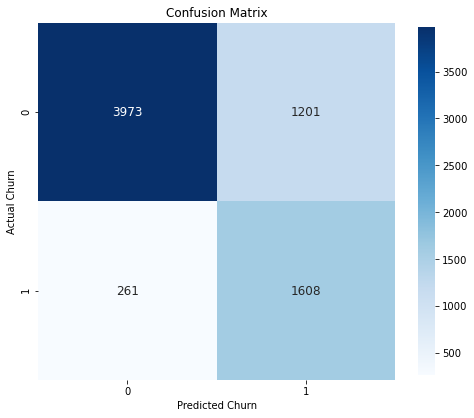

In [37]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',square=True, cbar_kws={'shrink':0.8}, annot_kws={'fontsize':12})
plt.title('Confusion Matrix')
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

# plt.savefig('../images/confusion_matrix.png')

plt.show()

In [38]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (fp + tp) 

print("Sensitivity: ", round(sensitivity,2))
print("Specificity: ", round(specificity,2))
print("Precision:", round(precision ,2))
print("Accuracy: ", round((tn + tp) / (tn + fp + tp + fn),2))
print("Misclassification: ", round((1-(tn + tp) / (tn + fp + tp + fn)),2))

Sensitivity:  0.86
Specificity:  0.77
Precision: 0.57
Accuracy:  0.79
Misclassification:  0.21


## ROC AUC

In [39]:
#calculate TPR and TNR
TPR = sensitivity
print("True Positive Rate: ", round(TPR,2))
TNR = 1 - specificity
print("True Negative Rate (False Positive Rate)", round(TNR,2))

True Positive Rate:  0.86
True Negative Rate (False Positive Rate) 0.23


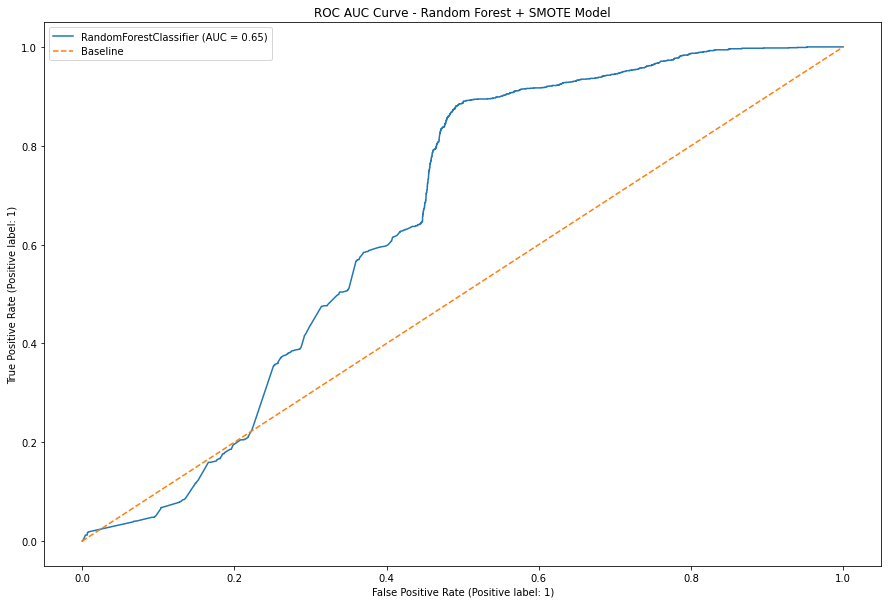

In [40]:
#plot ROC AUC curve for RF model
fig, ax = plt.subplots(figsize=(15, 10))
plot_roc_curve(best_model,X,y,ax=ax)
plt.plot([0,1],[0,1], color='tab:orange', linestyle='--', label='Baseline')

plt.title('ROC AUC Curve - Random Forest + SMOTE Model')
plt.legend()
# plt.savefig('../images/ROC_AUC.png')
plt.show()

In [41]:
#focus is reduce FPR, 

### Checking False Negative Classification to learn from and implement for false positive customer

In [42]:
#whether false positive is a prealert

In [43]:
#false positive
false = pred_df[(pred_df.true_values == 0) & (pred_df.preds_value == 1)]
false.to_csv('../data/telco_false_class.csv')

In [44]:
#predicted to stay but churned
miss_cust = pred_df[(pred_df.true_values == 1) & (pred_df.preds_value == 0)]

#for survival analysis check 
miss_cust.to_csv('../data/telco_miss_class.csv')

,true_values,preds_value
7,1,0
21,1,0
25,1,0
35,1,0
36,1,0
...,...,...
2518,1,0
2525,1,0
2530,1,0
2532,1,0


In [46]:
miss_cust = telco_final.loc[miss_cust.index]
miss_cust.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,cluster
7,0,66,0,1,1,0,0,Sierra Madre,58,0,0,DSL,0,1,1,0,0,1,Month-to-month,1,Electronic check,1,100,5444,Service dissatisfaction,1,6,Offer B,0.00,DSL,24,0,1,45.30,2651.20,40.95,0,0.00,2610.25,1,1,Dissatisfaction,3698,0,vanilla
21,1,70,0,1,0,0,0,El Cajon,54,1,1,DSL,1,1,0,1,1,1,One year,0,Bank transfer (automatic),1,83,4149,Long distance charges,0,0,Offer B,12.08,DSL,5,1,1,82.45,4350.10,0.00,0,652.32,5002.42,1,1,Competitor,5188,0,heavyweight
25,0,79,0,1,1,0,0,Indian Wells,11,1,0,No,0,0,0,0,0,0,Month-to-month,0,Mailed check,1,80,5888,Limited range of services,1,1,None,29.54,None,0,0,0,19.95,214.75,0.00,0,324.94,539.69,1,1,Competitor,358,0,minimalist
35,1,78,0,1,1,0,0,Yorba Linda,65,1,1,Fiber optic,1,0,1,0,1,1,Month-to-month,0,Bank transfer (automatic),1,91,4196,Competitor offered higher download speeds,1,3,Offer B,18.39,Fiber Optic,28,0,1,105.25,6786.40,0.00,0,1195.35,7981.75,1,1,Attitude,2226,0,heavyweight
36,0,75,0,1,1,0,0,Summerland,49,1,1,Fiber optic,0,1,0,0,0,1,Month-to-month,0,Credit card (automatic),1,96,5059,Competitor made better offer,1,3,Offer B,22.92,Fiber Optic,14,0,1,90.05,4547.25,0.00,0,1123.08,5670.33,2,1,Competitor,1519,0,heavyweight


In [47]:
miss_cust.tenure_months.value_counts().value_counts()
#far lesser than predicted survival analysis

3     14
1     11
2     11
4     11
5      8
6      8
7      5
8      1
11     1
Name: tenure_months, dtype: int64

In [48]:
miss_cust.contract.value_counts()

Month-to-month    125
One year           90
Two year           46
Name: contract, dtype: int64

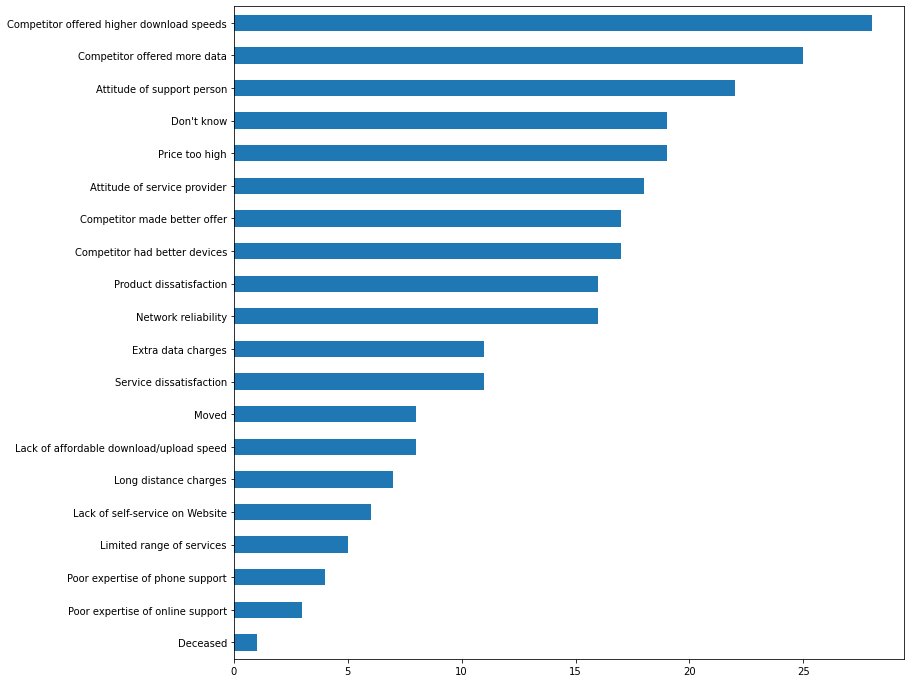

In [49]:
plt.figure(figsize=(12,12))
miss_cust.churn_reason.value_counts().sort_values(ascending=True).plot(kind='barh')
plt.show()

In [50]:
miss_cust.offer.value_counts()

None       146
Offer B     37
Offer D     24
Offer A     23
Offer E     17
Offer C     14
Name: offer, dtype: int64

In [51]:
plt.figure(figsize=(12,12))
pd.crosstab(index=miss_cust.offer, columns=miss_cust.contract)

contract,Month-to-month,One year,Two year
offer,,,
None,75,48,23
Offer A,2,6,15
Offer B,9,21,7
Offer C,6,7,1
Offer D,19,5,0
Offer E,14,3,0


<Figure size 864x864 with 0 Axes>

In [52]:
miss_cust.cluster.value_counts() 

heavyweight        107
vanilla            100
minimalist          44
price_sensitive     10
Name: cluster, dtype: int64

In [53]:
pd.crosstab(index=miss_cust.cluster, columns=miss_cust.contract)

contract,Month-to-month,One year,Two year
cluster,,,
heavyweight,26,44,37
minimalist,30,9,5
price_sensitive,10,0,0
vanilla,59,37,4


In [54]:
mode_df = miss_cust.select_dtypes(exclude='number')

mode_df.groupby('cluster').agg([pd.Series.mode])

,city,internet_service,contract,payment_method,churn_reason,offer,internet_type,churn_category
,mode,mode,mode,mode,mode,mode,mode,mode
cluster,,,,,,,,
heavyweight,Los Angeles,Fiber optic,One year,Bank transfer (automatic),Competitor offered more data,None,Fiber Optic,Competitor
minimalist,San Diego,No,Month-to-month,Mailed check,"[Attitude of support person, Competitor offere...",None,None,Attitude
price_sensitive,"[Altadena, California Hot Springs, Camp Nelson...",Fiber optic,Month-to-month,"[Bank transfer (automatic), Electronic check]",Attitude of support person,None,Fiber Optic,Competitor
vanilla,Los Angeles,DSL,Month-to-month,Mailed check,Competitor offered higher download speeds,None,DSL,Competitor


In [55]:
miss_cust.groupby('cluster').agg(['min', 'max'])[['age','tenure_months','churn_score','cltv','avg_monthly_long_distance_charges',
                                                'avg_monthly_gb_download','monthly_charge','total_charges','total_extra_data_charges',
                                               'total_long_distance_charges','total_revenue']]

age     tenure_months     churn_score       cltv        \
                min max           min max         min  max   min   max   
cluster                                                                  
heavyweight      20  80            32  72          65  100  2071  6452   
minimalist       19  79             1  61          65  100  2102  6484   
price_sensitive  26  75             6  27          68   94  2283  5719   
vanilla          19  80             1  71          65  100  2003  6347   

                avg_monthly_long_distance_charges         \
                                              min    max   
cluster                                                    
heavyweight                                  0.00  49.98   
minimalist                                   2.58  49.74   
price_sensitive                              1.51  49.20   
vanilla                                      0.00  48.93   

                avg_monthly_gb_download     monthly_charge          \
                                    min max            min     max   
cluster                                                              
heavyweight                           2  82          54.20  118.35   
minimalist                            0   0          18.95   25.90   
price_sensitive                       3  51          44.60  104.30   
vanilla                               2  85          28.60  105.95   

                total_charges          total_extra_data_charges       \
                          min      max                      min  max   
cluster                                                                
heavyweight           2934.30  8684.80                        0  150   
minimalist              19.75  1334.00                        0    0   
price_sensitive        260.80  2867.75                        0    0   
vanilla                 49.25  3692.85                        0  150   

                total_long_distance_charges          total_revenue            
                                        min      max           min       max  
cluster                                                                       
heavyweight                            0.00  3508.82       3858.91  11195.44  
minimalist                            11.91  2822.47         31.66   4005.02  
price_sensitive                       27.18   831.60        556.00   3142.88  
vanilla                                0.00  2079.20         57.63   4835.75

 # Quadrant Focus

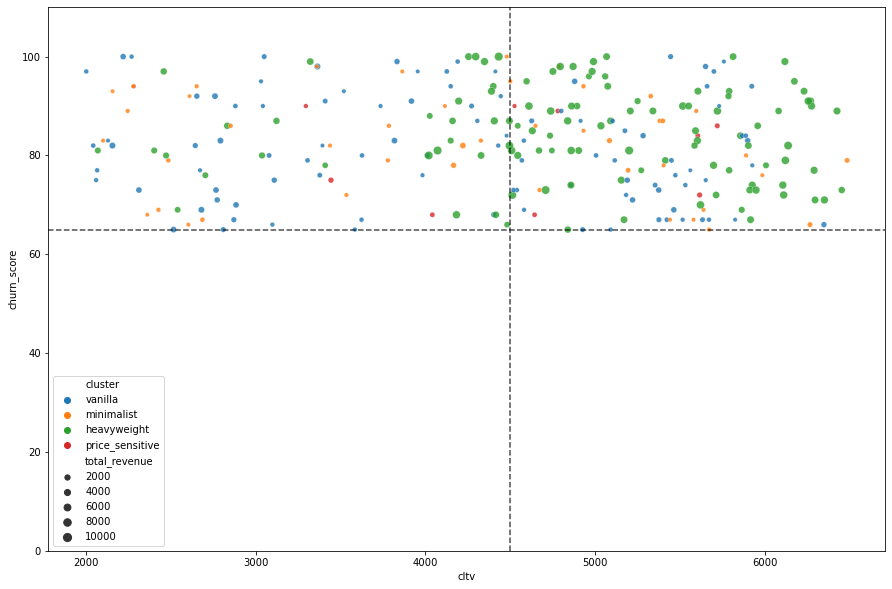

In [56]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=telco_final.loc[miss_cust.index], x='cltv',y='churn_score', hue='cluster', hue_order=['vanilla','minimalist','heavyweight','price_sensitive'], size='total_revenue', alpha=0.8)
plt.ylim(0,110)
plt.legend(loc='lower left')
plt.axhline(y=65,c='k',linestyle='--',alpha=0.7)
plt.axvline(x=4500,c='k',linestyle='--',alpha=0.7)

plt.show()
#marking for top value

## Statistical inference

how confident from the sample to the population 